## Looking at performance data

Did some performance tests to check how a container is running

```
$ docker stats gconsumption --format "{\"container\":\"{{ .Container }}\",\"memory\":\"{{ .MemUsage }}\",\"cpu\":\"{{ .CPUPerc }}\"" | while read line; do echo "$line,\"ts\": \"$(date +"%T.%2N")\"}"; done | tee docker_stats_bigtest.json
```

This will track all the memory usage and cpu of a container over time with a timestamp and write it to a file.  This notebook will look up and parse the file for analysis

Notebook requires matplotlib and pandas installed

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
try:
    import seaborn as sns
    sns.set() # prettier plots
except ImportError:
    print('No seaborn, ugly plots it is!')

In [2]:
## Read and parse the lines to a dataframe
import json


def clean_line(line):
    line = line[7:] # for some reason the shell command above adds some junk in front of line
    line = line.replace('}', '')
    line = line.replace('\n', '')
    line += '}'
    return line


data = []
with open('docker_stats_bigtest.json') as f:
    for line in f:
        line = clean_line(line)
        data.append(json.loads(line))

df = pd.DataFrame(data)
df.head()

,container,cpu,memory,ts
0,gconsumption,0.00%,77.78MiB / 31.35GiB,11:29:34.88
1,gconsumption,0.00%,77.78MiB / 31.35GiB,11:29:35.38
2,gconsumption,0.00%,77.78MiB / 31.35GiB,11:29:35.88
3,gconsumption,0.00%,77.78MiB / 31.35GiB,11:29:36.38
4,gconsumption,0.00%,77.78MiB / 31.35GiB,11:29:36.88


In [3]:
## Clean the dataframe

df['mem_unit'] = df['memory'].str.extract('([A-Z]\w{0,})', expand=True)
df['memory'] = df['memory'].str.extract('(\d*\.\d+|\d+)M?G?iB /', expand=False).astype(float)
df['cpu'] = df['cpu'].str.replace('%','').astype('float16')
df.index = pd.to_datetime(df['ts'])
df.drop('ts', axis=1, inplace=True)

#df.loc['2019-07-08 12',:].head()
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4790 entries, 2019-07-08 11:29:34.880000 to 2019-07-08 12:09:29.380000
Data columns (total 4 columns):
container    4790 non-null object
cpu          4790 non-null float16
memory       4790 non-null float64
mem_unit     4790 non-null object
dtypes: float16(1), float64(1), object(2)
memory usage: 159.0+ KB


In [4]:
df.loc[df['mem_unit'] == 'GiB', 'memory'] = df[df['mem_unit'] == 'GiB']['memory']*1000
#df.loc['2019-07-08 11:57':'2019-07-08 12:00'].head()

/tmp/tmp.D4naVoM3V9/venv/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'timestamp')

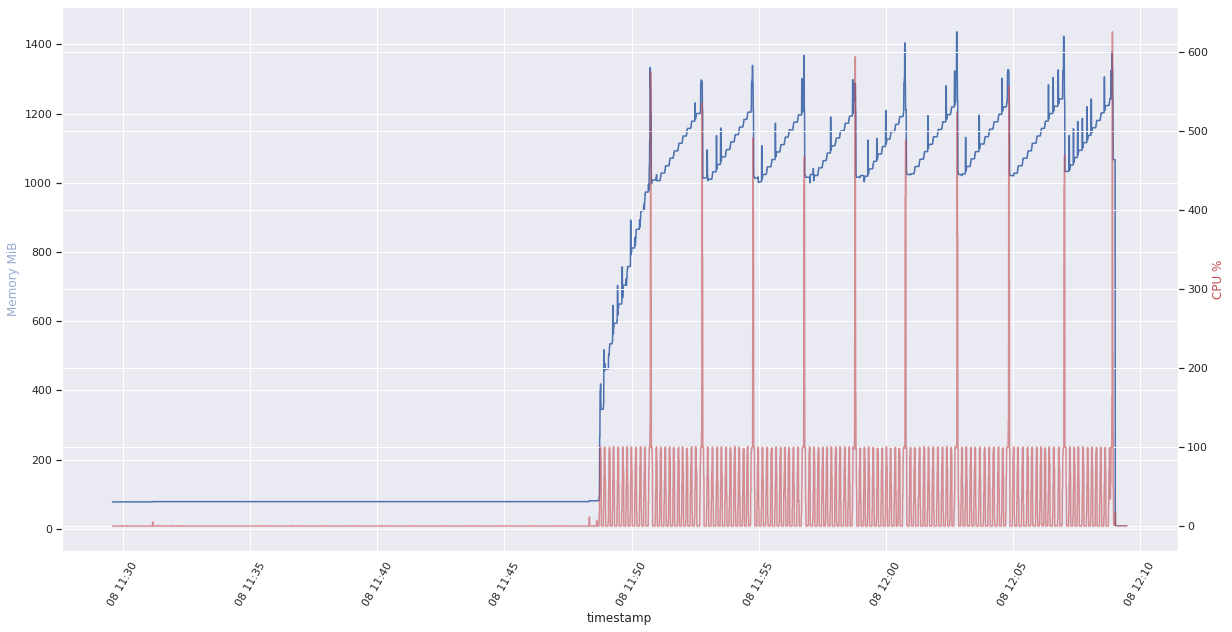

In [5]:
plt.rcParams['figure.figsize'] = [20, 10]
fig, ax1 = plt.subplots()
plt.xticks(rotation=60)
ax1.plot(df.index, df['memory'])
ax1.set_ylabel('Memory MiB', color='b', alpha=0.6)

ax2 = ax1.twinx()
ax2.plot(df.index, df['cpu'], c='r', alpha=0.6)
ax2.set_ylabel('CPU %', color='r')
ax1.set_xlabel('timestamp')

In [6]:
print(f"Max memory {df['memory'].max()}")
print(f"Max cpu usage {df['cpu'].max()}%")

Max memory 1.436
Max cpu usage 625.0%
